In [1]:
# Imports
import os
import cv2
import numpy as np
import opencv_jupyter_ui as jcv2

## jan 2025 - 7 node motorized casterbot with printed springs
* pick colors
* create mask for each color
* get trajectories for each color
* like nearest trajectories across colors
* calculate statistics

# Pick Colors

In [2]:
def bgr2hsv(pixel):
    """Converts a single BGR pixel to HSV."""

    # Convert the pixel to a numpy array
    pixel = np.array(pixel, dtype=np.float32) / 255.0 

    # Convert BGR to HSV using OpenCV
    hsv = cv2.cvtColor(np.array([[pixel]]), cv2.COLOR_BGR2HSV)

    # Extract the HSV values
    h, s, v = hsv[0][0]
    s = s*100
    v = v*100

    return h, s, v

In [3]:
# Pick Colors

def get_pixel_color(event, x, y, flags, param):
    """Callback function to handle mouse clicks and display pixel color"""
    if event == cv2.EVENT_LBUTTONDOWN:
        # Get BGR color at clicked position
        bgr_color = frame[y, x]
        # Convert BGR to RGB
        rgb_color = bgr_color[::-1]
        hsv_color = bgr2hsv(bgr_color)
        
        # Print color information
        print(f"\nPixel at position ({x}, {y}):")
        print(f"RGB: {tuple(rgb_color)}")
        print(f"BGR: {tuple(bgr_color)}")
        print(f"HSV: {tuple(hsv_color)}")
        
        # Create a color display window
        color_display = np.full((100, 100, 3), bgr_color, dtype=np.uint8)
        cv2.imshow('Selected Color', color_display)

# Read the first frame of the video
video_path = './Data/012025/012025_1.mp4'
video = cv2.VideoCapture(video_path)
success, frame = video.read()

if not success:
    print("Error: Could not read the video file")
    exit()

# Create window and set mouse callback
cv2.imshow('Video Frame', frame)
cv2.setMouseCallback('Video Frame', get_pixel_color)

# Keep windows open until 'q' is pressed
print("Click anywhere on the image to get pixel color")
print("Press 'q' to quit")

while True:
    if cv2.waitKey(1) & 0xFF == ord('q'):
        break

# Clean up
video.release()
cv2.destroyAllWindows()

Click anywhere on the image to get pixel color
Press 'q' to quit

Pixel at position (1183, 1233):
RGB: (np.uint8(246), np.uint8(254), np.uint8(209))
BGR: (np.uint8(209), np.uint8(254), np.uint8(246))
HSV: (np.float32(70.6667), np.float32(17.716534), np.float32(99.60784))

Pixel at position (1427, 1320):
RGB: (np.uint8(251), np.uint8(252), np.uint8(143))
BGR: (np.uint8(143), np.uint8(252), np.uint8(251))
HSV: (np.float32(60.550476), np.float32(43.25396), np.float32(98.82353))

Pixel at position (1245, 1504):
RGB: (np.uint8(230), np.uint8(140), np.uint8(73))
BGR: (np.uint8(73), np.uint8(140), np.uint8(230))
HSV: (np.float32(25.605091), np.float32(68.260864), np.float32(90.196075))

Pixel at position (1454, 1303):
RGB: (np.uint8(255), np.uint8(190), np.uint8(89))
BGR: (np.uint8(89), np.uint8(190), np.uint8(255))
HSV: (np.float32(36.50602), np.float32(65.09803), np.float32(100.0))

Pixel at position (1457, 1307):
RGB: (np.uint8(182), np.uint8(120), np.uint8(80))
BGR: (np.uint8(80), np.uint

In [3]:
orange_color = np.array(bgr2hsv((42, 109, 241)))
green_color = np.array(bgr2hsv((58, 102, 57)))

orange = np.uint8([[[82,161,251 ]]])
orange_hsv = cv2.cvtColor(orange,cv2.COLOR_BGR2HSV)

green = np.uint8([[[143,252,246 ]]])
green_hsv = cv2.cvtColor(green,cv2.COLOR_BGR2HSV)


In [10]:
green_hsv

array([[[ 32, 110, 252]]], dtype=uint8)

# Mask Video

In [5]:
# Mask Video Function Definitions

def create_mask(frame, hsv_lower, hsv_upper, REDUCE=1):
    """
    Create a mask for the frame based on HSV color range
    """
    # Convert frame to HSV color space
    hsv = cv2.cvtColor(frame, cv2.COLOR_BGR2HSV)
    
    # Create mask using HSV range
    mask = cv2.inRange(hsv, hsv_lower, hsv_upper)
    
    # Apply morphological operations to reduce noise
    if REDUCE:
        kernel = np.ones((5,5), np.uint8)
        mask = cv2.erode(mask, kernel, iterations=1)
        mask = cv2.dilate(mask, kernel, iterations=1)
    
    return mask

def process_video(video_path, hsv_lower, hsv_upper, output_path=None):
    """
    Process video and apply HSV color masking
    """
    # Ensure input video exists
    if not os.path.exists(video_path):
        print(f"Error: Input video not found at {video_path}")
        return
    
    # Open video capture
    cap = cv2.VideoCapture(video_path)
    
    # Get video properties
    frame_width = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))
    frame_height = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))
    fps = int(cap.get(cv2.CAP_PROP_FPS))
    total_frames = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
    
    # Create video writer if output path is specified
    if output_path:
        output_dir = os.path.dirname(output_path)
        if output_dir and not os.path.exists(output_dir):
            os.makedirs(output_dir)
        fourcc = cv2.VideoWriter_fourcc(*'MJPG')
        out = cv2.VideoWriter(output_path, fourcc, fps, (frame_width, frame_height))
        print(f"Writing output to: {os.path.abspath(output_path)}")
    
    frame_count = 0
    while cap.isOpened() and frame_count < total_frames:
        ret, frame = cap.read()
        if not ret:
            break
            
        # Create mask
        mask = create_mask(frame, hsv_lower, hsv_upper)
        
        # Apply mask to original frame
        result = cv2.bitwise_and(frame, frame, mask=mask)
        
        # Display current frame number
        frame_count += 1
        print(f"Processing frame {frame_count}/{total_frames}")
        
        # Write frame if output path is specified
        if output_path:
            out.write(result)
    
    # Release resources
    cap.release()
    if output_path:
        out.release()
        print(f"Processing complete. Output video saved to: {os.path.abspath(output_path)}")


In [9]:
# Execute Mask, output mp4
    # Define HSV color range (example for blue)
    # You can adjust these values for different colors

# color = 25 # orange
# hsv_lower = np.array([color-30,100,100])   # Lower bound HSV values
# hsv_upper = np.array([color+30,255,255]) # Upper bound HSV values

# orange
color = 14
hsv_lower = np.array([color-20,100,100])   # Lower bound HSV values
hsv_upper = np.array([color+10,255,255]) # Upper bound HSV values
    
# color = 80 # green
# hsv_lower = np.array([color-20,50,50])   # Lower bound HSV values
# hsv_upper = np.array([color+10,255,255]) # Upper bound HSV values

# Process video
video_path = './Data/012025/012025_1.mp4'
output_path = "./Data/012025/012025_1_orange.avi"  # Optional
process_video(video_path, hsv_lower, hsv_upper, output_path)

Writing output to: /Users/alexleffell/Documents/PhD/tplax/Data/012025/012025_1_orange.avi
Processing frame 1/1000
Processing frame 2/1000
Processing frame 3/1000
Processing frame 4/1000
Processing frame 5/1000
Processing frame 6/1000
Processing frame 7/1000
Processing frame 8/1000
Processing frame 9/1000
Processing frame 10/1000
Processing frame 11/1000
Processing frame 12/1000
Processing frame 13/1000
Processing frame 14/1000
Processing frame 15/1000
Processing frame 16/1000
Processing frame 17/1000
Processing frame 18/1000
Processing frame 19/1000
Processing frame 20/1000
Processing frame 21/1000
Processing frame 22/1000
Processing frame 23/1000
Processing frame 24/1000
Processing frame 25/1000
Processing frame 26/1000
Processing frame 27/1000
Processing frame 28/1000
Processing frame 29/1000
Processing frame 30/1000
Processing frame 31/1000
Processing frame 32/1000
Processing frame 33/1000
Processing frame 34/1000
Processing frame 35/1000
Processing frame 36/1000
Processing frame 37

Processing frame 320/1000
Processing frame 321/1000
Processing frame 322/1000
Processing frame 323/1000
Processing frame 324/1000
Processing frame 325/1000
Processing frame 326/1000
Processing frame 327/1000
Processing frame 328/1000
Processing frame 329/1000
Processing frame 330/1000
Processing frame 331/1000
Processing frame 332/1000
Processing frame 333/1000
Processing frame 334/1000
Processing frame 335/1000
Processing frame 336/1000
Processing frame 337/1000
Processing frame 338/1000
Processing frame 339/1000
Processing frame 340/1000
Processing frame 341/1000
Processing frame 342/1000
Processing frame 343/1000
Processing frame 344/1000
Processing frame 345/1000
Processing frame 346/1000
Processing frame 347/1000
Processing frame 348/1000
Processing frame 349/1000
Processing frame 350/1000
Processing frame 351/1000
Processing frame 352/1000
Processing frame 353/1000
Processing frame 354/1000
Processing frame 355/1000
Processing frame 356/1000
Processing frame 357/1000
Processing f

Processing frame 637/1000
Processing frame 638/1000
Processing frame 639/1000
Processing frame 640/1000
Processing frame 641/1000
Processing frame 642/1000
Processing frame 643/1000
Processing frame 644/1000
Processing frame 645/1000
Processing frame 646/1000
Processing frame 647/1000
Processing frame 648/1000
Processing frame 649/1000
Processing frame 650/1000
Processing frame 651/1000
Processing frame 652/1000
Processing frame 653/1000
Processing frame 654/1000
Processing frame 655/1000
Processing frame 656/1000
Processing frame 657/1000
Processing frame 658/1000
Processing frame 659/1000
Processing frame 660/1000
Processing frame 661/1000
Processing frame 662/1000
Processing frame 663/1000
Processing frame 664/1000
Processing frame 665/1000
Processing frame 666/1000
Processing frame 667/1000
Processing frame 668/1000
Processing frame 669/1000
Processing frame 670/1000
Processing frame 671/1000
Processing frame 672/1000
Processing frame 673/1000
Processing frame 674/1000
Processing f

Processing frame 954/1000
Processing frame 955/1000
Processing frame 956/1000
Processing frame 957/1000
Processing frame 958/1000
Processing frame 959/1000
Processing frame 960/1000
Processing frame 961/1000
Processing frame 962/1000
Processing frame 963/1000
Processing frame 964/1000
Processing frame 965/1000
Processing frame 966/1000
Processing frame 967/1000
Processing frame 968/1000
Processing frame 969/1000
Processing frame 970/1000
Processing frame 971/1000
Processing frame 972/1000
Processing frame 973/1000
Processing frame 974/1000
Processing frame 975/1000
Processing frame 976/1000
Processing frame 977/1000
Processing frame 978/1000
Processing frame 979/1000
Processing frame 980/1000
Processing frame 981/1000
Processing frame 982/1000
Processing frame 983/1000
Processing frame 984/1000
Processing frame 985/1000
Processing frame 986/1000
Processing frame 987/1000
Processing frame 988/1000
Processing frame 989/1000
Processing frame 990/1000
Processing frame 991/1000
Processing f

In [20]:
# Frame Test
delta = np.array([10,10,10])
color = 40
hsv_lower = np.array([color-20,20,20])   # Lower bound HSV values
hsv_upper = np.array([color+20,255,255]) # Upper bound HSV values


video_path = './Data/012025/012025_1.mp4'
video = cv2.VideoCapture(video_path)
success, frame = video.read()
if not success:
    print("Error: Could not read the video file")
    exit()

# Create mask
mask = create_mask(frame, hsv_lower, hsv_upper, 1)
type(mask)

# Apply mask to original frame
result = cv2.bitwise_and(frame, frame, mask=mask)

# Display original frame, mask, and result
jcv2.imshow('Original', frame,width=1000)
cv2.imshow('Mask', mask)
jcv2.imshow('Result', result,width=1000)

# while True:
#     if jcv2.waitKey(1) & 0xFF == ord('q'):
#         break

# Clean up
video.release()
jcv2.destroyAllWindows()
cv2.destroyAllWindows()
                     


In [483]:
# Make difference video

# Define input and output video file paths
input_video_path = './Data/010825/010825_1.mp4'  # Replace with your MP4 video file
output_video_path = './Data/010825/010825_1_diff.avi'

# Open the video file
cap = cv2.VideoCapture(input_video_path)
if not cap.isOpened():
    print("Error: Cannot open the video file.")
    exit()

# Get video properties
frame_width = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))
frame_height = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))
fps = int(cap.get(cv2.CAP_PROP_FPS))

# Define codec and create VideoWriter object
fourcc = cv2.VideoWriter_fourcc(*'MJPG')
out = cv2.VideoWriter(output_video_path, fourcc, fps, (frame_width, frame_height), isColor=True)

# Read the first frame
ret, prev_frame = cap.read()
if not ret:
    print("Error: Cannot read the first frame from the video.")
    cap.release()
    exit()

while True:
    # Read the next frame
    ret, curr_frame = cap.read()
    if not ret:
        break

    # Compute the absolute difference between the current frame and the previous frame for each channel
    frame_diff = cv2.absdiff(curr_frame, prev_frame)

    # Write the frame difference to the output video
    out.write(frame_diff)

    # Update the previous frame
    prev_frame = curr_frame

# Release resources
cap.release()
out.release()
cv2.destroyAllWindows()

print("Frame differences have been saved to", output_video_path)

Frame differences have been saved to ./Data/010825/010825_1_diff.avi


# Get Trajectories

## use trackmate in imagej now
* trying with 010625_4.mp4
* first resize masked videos so first dimension is 1500x1003 pixels (constrain aspect ratio) so that trackmate runs faster
* 890 frames

In [183]:
import xml.etree.ElementTree as ET

def parse_trackmate_xml(xml_path):
    """
    Parse TrackMate XML file and extract particle tracks.
    
    Parameters:
    xml_path (str): Path to the TrackMate XML file
    
    Returns:
    DataFrame: Contains all particle tracks with their positions over time
    """
    # Parse XML file
    tree = ET.parse(xml_path)
    root = tree.getroot()
    
    # List to store all particle data
    all_particles = []
    
    # Iterate through each particle track
    j = 0
    for particle in root.findall('./particle'):        
        # Process each row (timepoint) for this particle
        for row in particle.findall('./detection'):
            particle_data = {
                'particle_id': j,
                'timestamp': float(row.get('t')),
                'x': float(row.get('x')),
                'y': float(row.get('y')),
            }
            all_particles.append(particle_data)
        j+=1
    
    # Convert to DataFrame
    df = pd.DataFrame(all_particles)
    
    # Sort by particle_id and timestamp
    df = df.sort_values(['particle_id', 'timestamp'])
    
    return df

In [2]:
# Track Interpolation Functions
import xml.etree.ElementTree as ET
import pandas as pd
import numpy as np

def interpolate_tracks(df, max_timesteps=890):
    """
    Interpolate missing timesteps in particle tracks, maintaining existing data
    and only filling gaps with increments of 1.
    
    Parameters:
    df (pd.DataFrame): DataFrame containing particle tracks with columns 
                      ['particle_id', 'timestamp', 'x', 'y', 'z']
    max_timesteps (int): Maximum number of timesteps expected (0 to max_timesteps-1)
    
    Returns:
    pd.DataFrame: DataFrame with interpolated tracks
    """
    # Create a list to store interpolated data for each particle
    interpolated_data = []
    
    # Get unique particle IDs
    particle_ids = df['particle_id'].unique()
    
    # Process each particle
    for particle_id in particle_ids:
        # Get data for this particle
        particle_data = df[df['particle_id'] == particle_id].copy()
        
        # Create a DataFrame with all timesteps from 0 to max_timesteps-1
        all_timesteps = pd.DataFrame({
            'timestamp': range(max_timesteps),
            'particle_id': particle_id
        })
        
        # Merge with actual data
        merged = pd.merge(all_timesteps, particle_data, 
                         on=['particle_id', 'timestamp'], 
                         how='left')
        
        # Interpolate missing values
        merged['x'] = merged['x'].interpolate(method='linear')
        merged['y'] = merged['y'].interpolate(method='linear')
        
#         # Only keep rows between first and last actual measurements
#         first_measurement = particle_data['timestamp'].min()
#         last_measurement = particle_data['timestamp'].max()
#         merged = merged[
#             (merged['timestamp'] >= first_measurement) & 
#             (merged['timestamp'] <= last_measurement)
#         ]
        
        interpolated_data.append(merged)
    
    # Combine all interpolated tracks
    interpolated_df = pd.concat(interpolated_data, ignore_index=True)
    
    # Sort by particle_id and timestamp
    interpolated_df = interpolated_df.sort_values(['particle_id', 'timestamp'])
    
    # Calculate statistics about interpolation
    stats = calculate_interpolation_stats(df, interpolated_df)
    print_interpolation_stats(stats)
    
    return interpolated_df

def calculate_interpolation_stats(original_df, interpolated_df):
    """
    Calculate statistics about the interpolation process.
    """
    stats = {
        'original_rows': len(original_df),
        'interpolated_rows': len(interpolated_df),
        'particles': len(original_df['particle_id'].unique()),
        'added_points': len(interpolated_df) - len(original_df)
    }
    
    # Calculate gaps filled per particle
    particle_stats = []
    gap_sizes = []
    for particle_id in original_df['particle_id'].unique():
        # Original timestamps for this particle
        orig_times = set(original_df[original_df['particle_id'] == particle_id]['timestamp'])
        
        # Get all timestamps after interpolation
        interp_times = set(interpolated_df[interpolated_df['particle_id'] == particle_id]['timestamp'])
        
        # Calculate gaps
        filled_points = len(interp_times - orig_times)
        total_points = len(interp_times)
        
        # Calculate gap sizes
        orig_times_list = sorted(list(orig_times))
        for i in range(len(orig_times_list) - 1):
            gap = orig_times_list[i + 1] - orig_times_list[i] - 1
            if gap > 0:
                gap_sizes.append(gap)
        
        particle_stats.append((filled_points / total_points) * 100)
    
    stats['avg_interpolated_percentage'] = np.mean(particle_stats)
    stats['max_interpolated_percentage'] = np.max(particle_stats)
    stats['avg_gap_size'] = np.mean(gap_sizes) if gap_sizes else 0
    stats['max_gap_size'] = np.max(gap_sizes) if gap_sizes else 0
    
    return stats

def print_interpolation_stats(stats):
    """
    Print statistics about the interpolation process.
    """
    print("\nInterpolation Statistics:")
    print(f"Original number of points: {stats['original_rows']}")
    print(f"Interpolated number of points: {stats['interpolated_rows']}")
    print(f"Number of particles: {stats['particles']}")
    print(f"Added points: {stats['added_points']}")
    print(f"Average percentage of interpolated points per particle: {stats['avg_interpolated_percentage']:.2f}%")
    print(f"Maximum percentage of interpolated points for any particle: {stats['max_interpolated_percentage']:.2f}%")
    print(f"Average gap size: {stats['avg_gap_size']:.2f}")
    print(f"Maximum gap size: {stats['max_gap_size']}")



A module that was compiled using NumPy 1.x cannot be run in
NumPy 2.0.2 as it may crash. To support both 1.x and 2.x
versions of NumPy, modules must be compiled with NumPy 2.0.
Some module may need to rebuild instead e.g. with 'pybind11>=2.12'.

If you are a user of the module, the easiest solution will be to
downgrade to 'numpy<2' or try to upgrade the affected module.
We expect that some modules will need time to support NumPy 2.

Traceback (most recent call last):  File "/Users/alexleffell/opt/anaconda3/lib/python3.9/runpy.py", line 197, in _run_module_as_main
    return _run_code(code, main_globals, None,
  File "/Users/alexleffell/opt/anaconda3/lib/python3.9/runpy.py", line 87, in _run_code
    exec(code, run_globals)
  File "/Users/alexleffell/opt/anaconda3/lib/python3.9/site-packages/ipykernel_launcher.py", line 16, in <module>
    app.launch_new_instance()
  File "/Users/alexleffell/opt/anaconda3/lib/python3.9/site-packages/traitlets/config/application.py", line 846, in launch

AttributeError: _ARRAY_API not found


A module that was compiled using NumPy 1.x cannot be run in
NumPy 2.0.2 as it may crash. To support both 1.x and 2.x
versions of NumPy, modules must be compiled with NumPy 2.0.
Some module may need to rebuild instead e.g. with 'pybind11>=2.12'.

If you are a user of the module, the easiest solution will be to
downgrade to 'numpy<2' or try to upgrade the affected module.
We expect that some modules will need time to support NumPy 2.

Traceback (most recent call last):  File "/Users/alexleffell/opt/anaconda3/lib/python3.9/runpy.py", line 197, in _run_module_as_main
    return _run_code(code, main_globals, None,
  File "/Users/alexleffell/opt/anaconda3/lib/python3.9/runpy.py", line 87, in _run_code
    exec(code, run_globals)
  File "/Users/alexleffell/opt/anaconda3/lib/python3.9/site-packages/ipykernel_launcher.py", line 16, in <module>
    app.launch_new_instance()
  File "/Users/alexleffell/opt/anaconda3/lib/python3.9/site-packages/traitlets/config/application.py", line 846, in launch

AttributeError: _ARRAY_API not found

In [437]:
# centers_xml = "./Data/010625/010625_4_green_Tracks.xml"
# indicator_xml = "./Data/010625/010625_4_orange_Tracks.xml"
centers_xml = "./Data/010825/010825_1_green_Tracks.xml"
indicator_xml = "./Data/010825/010825_1_orange_Tracks.xml"
centers_spots_df = parse_trackmate_xml(centers_xml)
indicator_spots_df = parse_trackmate_xml(indicator_xml)

In [438]:
# now interpolate so they all have the same length
nFrames = 1000
centers_spots_df_interp = interpolate_tracks(centers_spots_df, max_timesteps=nFrames)
indicator_spots_df_interp = interpolate_tracks(indicator_spots_df, max_timesteps=nFrames)


Interpolation Statistics:
Original number of points: 6679
Interpolated number of points: 7000
Number of particles: 7
Added points: 321
Average percentage of interpolated points per particle: 4.59%
Maximum percentage of interpolated points for any particle: 21.20%
Average gap size: 1.67
Maximum gap size: 10.0

Interpolation Statistics:
Original number of points: 6748
Interpolated number of points: 7000
Number of particles: 7
Added points: 252
Average percentage of interpolated points per particle: 3.60%
Maximum percentage of interpolated points for any particle: 8.90%
Average gap size: 2.12
Maximum gap size: 19.0


In [439]:
# link centers and indicator based closest initial position
pair_ids = [] # list of tuples. first value is center particle_id and second is indicator particle_id

centers = centers_spots_df_interp
indicators = indicator_spots_df_interp

center_ids = centers['particle_id'].unique() 
indicator_ids = indicators['particle_id'].unique()

for center_id in center_ids:
    min_dist = 10000000
    min_id = 10
    df1 = centers[centers['particle_id'] == center_id].copy()
    
    for indicator_id in indicator_ids:
        df2 = indicators[indicators['particle_id'] == indicator_id].copy()
        dist = np.sqrt( (df1.iloc[0]["x"] - df2.iloc[0]["x"])**2 + (df1.iloc[0]["y"] - df2.iloc[0]["y"])**2  )
        if dist < min_dist:
            min_dist = dist
            min_id = indicator_id
    
    pair_ids.append((center_id,min_id, min_dist))

In [440]:
# Now make a dataframe for each node, store in list
node_list = []
#pair_ids = [(0,5) , (1,0), (2,2), (3,3), (4,4), (5,1), (6,6)]
for pair in pair_ids:
    center_id = pair[0]
    indicator_id = pair[1]
    
    df1 = centers[centers['particle_id'] == center_id]
    df2 = indicators[indicators['particle_id'] == indicator_id]
    t   = np.array(df1["timestamp"])
    x   = np.array(df1["x"])
    y   = np.array(df1["y"])
    x2  = np.array(df2["x"])
    y2  = np.array(df2["y"])
    
    
    data = {"timestamp":t, "node_id":center_id,"center_x":x, "center_y":y, "indicator_x":x2, "indicator_y":y2 }
    node_list.append(pd.DataFrame(data))
    

In [441]:
# add indicator data

for node in node_list:
    dists = []
    angles = []
    for row in node.iterrows():
        dx = row[1]["center_x"] - row[1]["indicator_x"]
        dy = row[1]["center_y"] - row[1]["indicator_y"]
        dists.append(np.sqrt( (dx)**2 + (dy)**2  ))
        angles.append( np.atan2( dx, dy) )
    node["indicator_dist"] = dists
    node["indicator_angles"] = angles



In [442]:
# determine central node to make body reference frame, then relabel nodes so 0 is in center, 1 defines line and increases clockwise

min_dist = 100000000
min_node = 0
for node in node_list:
    total_dist = 0
    for other_node in node_list:
        total_dist += np.sqrt( (node.iloc[0]["center_x"] - other_node.iloc[0]["center_x"])**2 + 
                              (node.iloc[0]["center_y"] - other_node.iloc[0]["center_y"])**2  )
    if total_dist < min_dist:
        min_dist = total_dist
        min_node = node
        
# pick another node to make a line. Frame will be right hand ruled off that. wont be perfect since whole thing
# is deforming
frame = (min_node, 1) # other node picked randomly by hand

body_angle = []
for t in min_node["timestamp"]:
    dx = min_node.iloc[t]["center_x"] - node_list[0].iloc[t]["center_x"]
    dy = min_node.iloc[t]["center_y"] - node_list[0].iloc[t]["center_y"]
    body_angle.append(np.atan2( dx, dy))
    

In [443]:
# Get rotated angles based on body frame
node = node_list[5]
for node in node_list:
    rotated = []
    for t in node["timestamp"]:
        theta = body_angle[t]
        rot_matrix = np.array( [ [np.cos(theta), -np.sin(theta)] , [np.sin(theta), np.cos(theta)] ] )
        x1 = node.iloc[t]["center_x"]
        x2 = node.iloc[t]["indicator_x"]
        y1 = node.iloc[t]["center_y"]
        y2 = node.iloc[t]["indicator_y"]

        p1 = np.array([x1,y1])
        p2 = np.array([x2,y2])

        r1 = rot_matrix@p1
        r2 = rot_matrix@p2

        dx = r1[0]-r2[0]
        dy = r1[1]-r2[1]

        rotated.append(np.atan2( dx, dy))
    node["in_frame_angle"] = rotated



In [444]:
# Generate data frame for robot. node ID's get moved around!!!!! 0 is center

fr = 30 #hz

robot_df = pd.DataFrame(min_node["timestamp"]/fr)
i = 1
min_node_id = min_node.iloc[0]["node_id"]

for node in node_list:
    disp = []
    node_id = int(node.iloc[0]["node_id"])
    x0 = node.iloc[0]["center_x"]
    y0 = node.iloc[0]["center_y"]

    for t in node["timestamp"]:
        disp.append( np.sqrt( (node.iloc[t]["center_x"] - x0)**2 + (node.iloc[t]["center_y"] - y0)**2 ) )
    if node_id == min_node_id:
        robot_df[str(0)+"_angle"] = node["in_frame_angle"]
        robot_df[str(0)+"_disp"] = disp
        robot_df[str(0)+"_x"] = node["center_x"]
        robot_df[str(0)+"_y"] = node["center_y"]
    else:
        robot_df[str(i)+"_angle"] = node["in_frame_angle"]
        robot_df[str(i)+"_disp"] = disp 
        robot_df[str(i)+"_x"] = node["center_x"]
        robot_df[str(i)+"_y"] = node["center_y"]
        i+=1
    
    

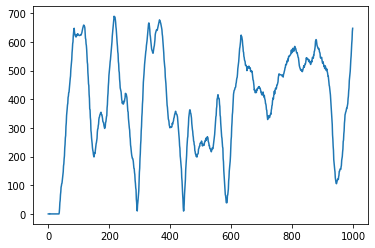

In [445]:
plt.plot(robot_df["0_disp"])

(0.0, 1003.0)

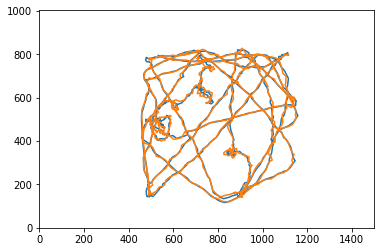

In [446]:
def plot_traj(x,y, xoff = 1500, yoff = 1003):
    plt.plot(x,-y+yoff)
    plt.xlim(0, xoff)
    plt.ylim(0, yoff)
    
node = min_node
plt.plot(node["center_x"], -node["center_y"]+1003)
plt.plot(node["indicator_x"], -node["indicator_y"]+1003)
plt.xlim(0, 1500)
plt.ylim(0, 1003)

# Try PCA

In [465]:
# PCA
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from scipy.signal import spectrogram
from sklearn.cluster import KMeans
from sklearn.cluster import DBSCAN


n = 29
cols = []
for i in range(n):
    cols.append("PC"+str(i+1))

# Standardize the data
scaler = StandardScaler()
scaled_data = scaler.fit_transform(robot_df)

# Apply PCA
pca = PCA(n_components=n)
principal_components = pca.fit_transform(scaled_data)
first_component_projected = np.array(pca.inverse_transform(principal_components))

# Create a new DataFrame with the principal components
pca_df = pd.DataFrame(data=principal_components, columns=cols)

pca.components_[0]



array([-0.08552191, -0.00574762, -0.24211065,  0.25246578,  0.04355934,
       -0.05480073, -0.25482626,  0.26703173, -0.04524925, -0.05611717,
       -0.2672226 ,  0.27625355, -0.03450577, -0.04893468, -0.27444531,
        0.28407051,  0.00685541, -0.02549137, -0.22299507,  0.25612345,
        0.02434299, -0.04975364, -0.24662068,  0.25756549, -0.01737057,
       -0.04437631, -0.28946961,  0.29032048, -0.0054052 ])

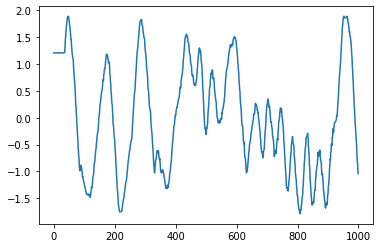

In [466]:
plt.plot(first_component_projected[:,7])

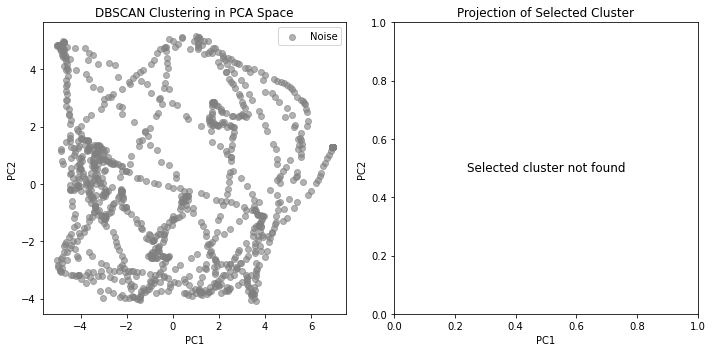

In [467]:
# Cluster the data (e.g., using k-means)
# kmeans = KMeans(n_clusters=3, random_state=2, init='k-means++')
# labels = kmeans.fit_predict(principal_components)

kmeans = DBSCAN(eps=0.6, min_samples=50)
labels = kmeans.fit_predict(principal_components)

# Extract a single cluster
cluster_index = 0  # Replace with the desired cluster index
cluster_mask = labels == cluster_index  # Create a boolean mask

if isinstance(data, pd.DataFrame):
    cluster_data = pca_df.loc[cluster_mask]  # For pandas DataFrame
else:
    cluster_data = pca_df[cluster_mask]      # For NumPy array

# Reproject the original data of the cluster
cluster_pca_projection = principal_components[cluster_mask]  # Extract cluster in PCA space



# Plot DBSCAN clustering
plt.figure(figsize=(10, 5))

# Subplot 1: DBSCAN clustering
plt.subplot(1, 2, 1)
unique_labels = set(labels)
for cluster_index in unique_labels:
    if cluster_index == -1:
        # Noise points
        cluster_points = principal_components[labels == cluster_index]
        plt.scatter(cluster_points[:, 0], cluster_points[:, 1], c='gray', label='Noise', alpha=0.6)
    else:
        cluster_points = principal_components[labels == cluster_index]
        plt.scatter(cluster_points[:, 0], cluster_points[:, 1], label=f'Cluster {cluster_index}')
plt.xlabel('PC1')
plt.ylabel('PC2')
plt.title('DBSCAN Clustering in PCA Space')
plt.legend()

# Subplot 2: Selected cluster projection
plt.subplot(1, 2, 2)
selected_cluster_index = 0  # Change to desired cluster index
if selected_cluster_index in unique_labels and selected_cluster_index != -1:
    cluster_mask = labels == selected_cluster_index
    cluster_pca_projection = principal_components[cluster_mask]
    plt.scatter(cluster_pca_projection[:, 0], cluster_pca_projection[:, 1], c='blue', label=f'Cluster {selected_cluster_index}')
    plt.xlabel('PC1')
    plt.ylabel('PC2')
    plt.title(f'Projection of Selected Cluster {selected_cluster_index}')
    plt.legend()
else:
    plt.text(0.5, 0.5, 'Selected cluster not found', ha='center', va='center', fontsize=12)
    plt.xlabel('PC1')
    plt.ylabel('PC2')
    plt.title('Projection of Selected Cluster')

plt.tight_layout()
plt.show()

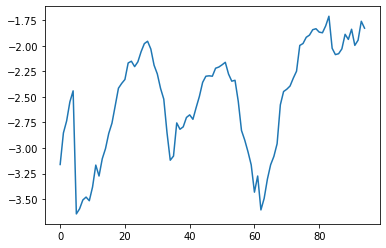

In [426]:
# Plot back-projection of main cluster
cluster_0 = [sum(cluster_pca_projection[i]) for i in range(len(cluster_pca_projection))]
plt.plot(cluster_0)

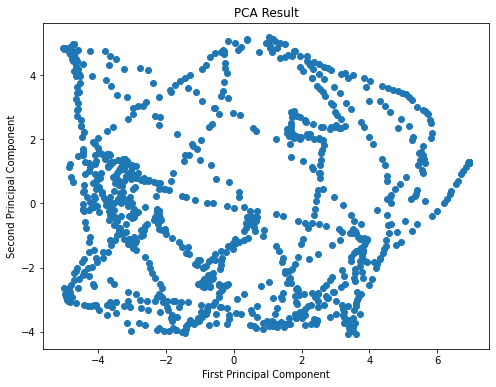

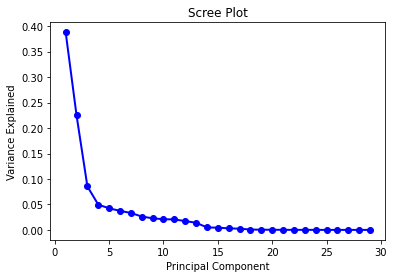

In [470]:
# Scatter plot of first two components and scree plot
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 6))
plt.scatter(pca_df['PC1'], pca_df['PC2'])
plt.xlabel('First Principal Component')
plt.ylabel('Second Principal Component')
plt.title('PCA Result')
plt.show()

# PCA Scree Plot
PC_values = np.arange(pca.n_components_) + 1
plt.plot(PC_values, pca.explained_variance_ratio_, 'o-', linewidth=2, color='blue')
plt.title('Scree Plot')
plt.xlabel('Principal Component')
plt.ylabel('Variance Explained')
plt.show()


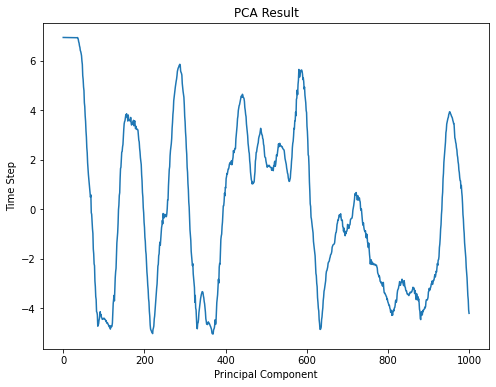

In [464]:
# Plot of first component
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 6))
plt.plot(pca_df['PC1'])
plt.xlabel('Principal Component')
plt.ylabel('Time Step')
plt.title('PCA Result')
plt.show()

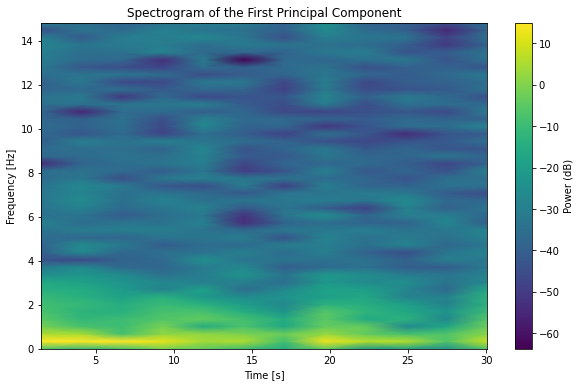

In [482]:
# Spectrogram of component
nperseg = 89  # Length of each segment
noverlap = 4  # Overlap between segments (50% overlap)

# Compute the spectrogram
spec_data = first_component_projected[:,7] # np.array(cluster_0)
frequencies, times, Sxx = spectrogram(pca_df['PC1'], fs=fr, nperseg=nperseg)  # Adjust `fs` to your sampling frequency
# frequencies, times, Sxx = spectrogram(spec_data, fs=fr, nperseg=nperseg)  # Adjust `fs` to your sampling frequency

# Plot the spectrogram
plt.figure(figsize=(10, 6))
plt.pcolormesh(times, frequencies, 10 * np.log10(Sxx), shading='gouraud')
plt.title("Spectrogram of the First Principal Component")
plt.ylabel("Frequency [Hz]")
plt.xlabel("Time [s]")
plt.colorbar(label="Power (dB)")
plt.savefig('PC1_Spectrogram.png')
plt.show()

# Get Bounce Angles

In [472]:
# Bounce angle function defs
from scipy.signal import butter, filtfilt, find_peaks

def low_pass_filter(data, cutoff, fs, order=4):
    """
    Apply a low-pass Butterworth filter to the data.

    Parameters:
    data (array): Input data to filter
    cutoff (float): Cutoff frequency for the filter
    fs (float): Sampling frequency
    order (int): Order of the Butterworth filter

    Returns:
    array: Filtered data
    """
    nyquist = 0.5 * fs  # Nyquist frequency
    normal_cutoff = cutoff / nyquist
    b, a = butter(order, normal_cutoff, btype='low', analog=False)
    return filtfilt(b, a, data)

def detect_collisions(t, x, y, threshold=0.5, cutoff=1.0):
    """
    Detect the time indices of collisions based on peaks in acceleration.

    Parameters:
    t (array): Time array
    x (array): X position array
    y (array): Y position array
    threshold (float): Threshold for peak detection
    cutoff (float): Cutoff frequency for the low-pass filter

    Returns:
    list of tuples: List of collision indices and types ('vertical' or 'horizontal')
    """
    dt = np.mean(np.diff(t))  # Time step
    fs = 1 / dt  # Sampling frequency

    # Calculate velocity components
    vx = np.gradient(x, t)
    vy = np.gradient(y, t)

    # Apply low-pass filter
    vx_filtered = low_pass_filter(vx, cutoff=cutoff, fs=fs)
    vy_filtered = low_pass_filter(vy, cutoff=cutoff, fs=fs)

    # Compute the change in filtered velocities (acceleration)
    ax = np.gradient(vx_filtered, t)
    ay = np.gradient(vy_filtered, t)

    # Detect peaks in acceleration
    vertical_peaks, _ = find_peaks(np.abs(ax), height=threshold)
    horizontal_peaks, _ = find_peaks(np.abs(ay), height=threshold)

    # Combine and label collisions
    collisions = [(i, 'vertical') for i in vertical_peaks] + [(i, 'horizontal') for i in horizontal_peaks]
    collisions.sort(key=lambda x: x[0])  # Sort by time index

    return collisions

def calculate_collision_angles(t, x, y, collision_index, collision_type, cutoff=1.0):
    """
    Calculate the incident and rebound angles of an object at the time of collision.

    Parameters:
    t (array): Time array
    x (array): X position array
    y (array): Y position array
    collision_index (int): Index of the detected collision
    collision_type (str): Type of collision ('vertical' or 'horizontal')
    cutoff (float): Cutoff frequency for the low-pass filter

    Returns:
    tuple: (incident_angle, rebound_angle) in degrees
    """
    dt = np.mean(np.diff(t))  # Time step
    fs = 1 / dt  # Sampling frequency

    # Calculate velocity components
    vx = np.gradient(x, t)
    vy = np.gradient(y, t)

    # Apply low-pass filter
    vx_filtered = low_pass_filter(vx, cutoff=cutoff, fs=fs)
    vy_filtered = low_pass_filter(vy, cutoff=cutoff, fs=fs)

    # Velocity vectors before and after collision
    if collision_type == 'vertical':
        vx_before, vy_before = vx_filtered[collision_index - 1], vy_filtered[collision_index - 1]
        vx_after, vy_after = vx_filtered[collision_index + 1], vy_filtered[collision_index + 1]
        incident_angle = np.degrees(np.arctan2(vy_before, -vx_before))
        rebound_angle = np.degrees(np.arctan2(vy_after, -vx_after))
    elif collision_type == 'horizontal':
        vx_before, vy_before = vx_filtered[collision_index - 1], vy_filtered[collision_index - 1]
        vx_after, vy_after = vx_filtered[collision_index + 1], vy_filtered[collision_index + 1]
        incident_angle = np.degrees(np.arctan2(-vx_before, vy_before))
        rebound_angle = np.degrees(np.arctan2(-vx_after, vy_after))
    else:
        raise ValueError("Invalid collision type. Must be 'vertical' or 'horizontal'.")

    return incident_angle, rebound_angle

def calculate_residence_time(t, x, y, collision_index, collision_type, cutoff=1.0, velocity_threshold=100):
    """
    Calculate the residence time at the wall during a collision.

    Parameters:
    t (array): Time array
    x (array): X position array
    y (array): Y position array
    collision_index (int): Index of the detected collision
    collision_type (str): Type of collision ('vertical' or 'horizontal')
    cutoff (float): Cutoff frequency for the low-pass filter
    velocity_threshold (float): Threshold for determining "zero" velocity

    Returns:
    float: Residence time in seconds
    """
    dt = np.mean(np.diff(t))  # Time step
    fs = 1 / dt  # Sampling frequency

    # Calculate velocity components
    vx = np.gradient(x, t)
    vy = np.gradient(y, t)

    # Apply low-pass filter
    vx_filtered = low_pass_filter(vx, cutoff=cutoff, fs=fs)
    vy_filtered = low_pass_filter(vy, cutoff=cutoff, fs=fs)

    # Select the velocity component based on collision type
    if collision_type == 'vertical':
        velocity = vx_filtered
    elif collision_type == 'horizontal':
        velocity = vy_filtered
    else:
        raise ValueError("Invalid collision type. Must be 'vertical' or 'horizontal'.")

    # Find the duration for which the velocity is near zero
    start = collision_index
    while start > 0 and np.abs(velocity[start]) < velocity_threshold:
        start -= 1

    end = collision_index
    while end < len(t) - 1 and np.abs(velocity[end]) < velocity_threshold:
        end += 1

    residence_time = t[end] - t[start]
    return residence_time

# # Example usage:
# if __name__ == "__main__":
#     # Example data: object moving and colliding with both walls
#     t = np.linspace(0, 10, 200)  # Time from 0 to 10 seconds
#     x = 5 * np.cos(2 * np.pi * t / 10)  # Circular motion
#     y = 5 * np.sin(2 * np.pi * t / 10)

#     # Introduce sharp changes to simulate collisions
#     x[80:] = x[80:] + 1  # Vertical collision
#     y[140:] = y[140:] - 2  # Horizontal collision

#     # Detect collisions
#     collisions = detect_collisions(t, x, y, threshold=1.0, cutoff=1.0)

#     if collisions:
#         for collision_index, collision_type in collisions:
#             print(f"Collision detected at t = {t[collision_index]:.2f}s (index {collision_index}, type {collision_type})")
#             incident, rebound = calculate_collision_angles(t, x, y, collision_index, collision_type, cutoff=1.0)
#             residence_time = calculate_residence_time(t, x, y, collision_index, collision_type, cutoff=1.0)
#             print(f"  Incident Angle: {incident:.2f}°")
#             print(f"  Rebound Angle: {rebound:.2f}°")
#             print(f"  Residence Time: {residence_time:.2f}s")
#     else:
#         print("No collisions detected.")



In [473]:
# Compute velocity vector of central node
x = min_node["center_x"]
y = min_node["center_y"]
t = min_node["timestamp"]/fr

fs = 30
cutoff = 1
# vx = np.gradient(x, t)
# vx_filtered = low_pass_filter(vx, cutoff=cutoff, fs=fs)
# plt.plot(t[0:100],vx[0:100],t[0:100],vx_filtered[0:100])


collisions = detect_collisions(t, x, y, threshold=1000.0, cutoff=1.0)
ratios = []
residence_times = []

if collisions:
    for collision_index, collision_type in collisions:
        print(f"Collision detected at t = {t[collision_index]:.2f}s (index {collision_index}, type {collision_type})")
        incident, rebound = calculate_collision_angles(t, x, y, collision_index, collision_type, cutoff=1.0)
        residence_time = calculate_residence_time(t, x, y, collision_index, collision_type, cutoff=1.0,velocity_threshold=100)
        ratios.append(rebound/incident)
        residence_times.append(residence_time)
        print(f"  Incident Angle: {incident:.2f}°")
        print(f"  Rebound Angle: {rebound:.2f}°")
        print(f"  Residence Time: {residence_time:.3f} s")
else:
    print("No collisions detected.")


Collision detected at t = 1.60s (index 48, type vertical)
  Incident Angle: -73.81°
  Rebound Angle: -66.37°
  Residence Time: 0.000 s
Collision detected at t = 2.10s (index 63, type horizontal)
  Incident Angle: 108.07°
  Rebound Angle: 99.20°
  Residence Time: 0.000 s
Collision detected at t = 2.77s (index 83, type vertical)
  Incident Angle: 31.36°
  Rebound Angle: 39.32°
  Residence Time: 0.000 s
Collision detected at t = 3.90s (index 117, type horizontal)
  Incident Angle: -31.66°
  Rebound Angle: -63.66°
  Residence Time: 0.000 s
Collision detected at t = 5.60s (index 168, type horizontal)
  Incident Angle: -133.60°
  Rebound Angle: -128.20°
  Residence Time: 0.000 s
Collision detected at t = 5.87s (index 176, type vertical)
  Incident Angle: 42.53°
  Rebound Angle: 34.73°
  Residence Time: 0.000 s
Collision detected at t = 7.23s (index 217, type vertical)
  Incident Angle: 45.24°
  Rebound Angle: 74.95°
  Residence Time: 0.000 s
Collision detected at t = 8.50s (index 255, type h

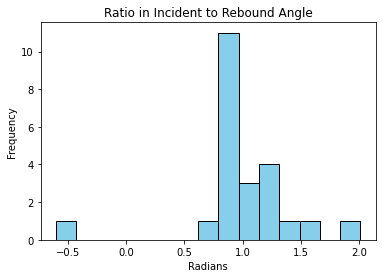

In [481]:
# Create histogram
plt.hist(ratios, bins='auto', color='skyblue', edgecolor='black')

# Add labels and title
plt.xlabel('Radians')
plt.ylabel('Frequency')
plt.title('Ratio in Incident to Rebound Angle')
plt.savefig('rebound_hist.png')
# Display the plot
plt.show()


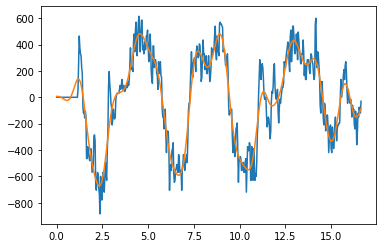

In [475]:
vx = np.gradient(x, t)
vx_filtered = low_pass_filter(vx, cutoff=cutoff, fs=fs)
n = 500
plt.plot(t[0:n],vx[0:n],t[0:n],vx_filtered[0:n])

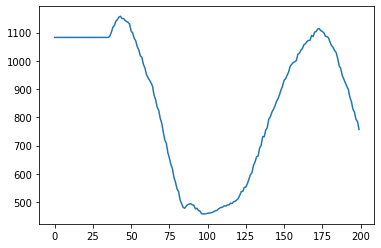

In [476]:
plt.plot(x[0:200])

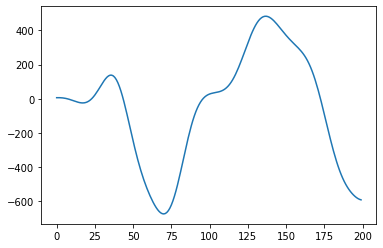

In [477]:
plt.plot(vx_filtered[0:200])

(0.0, 1003.0)

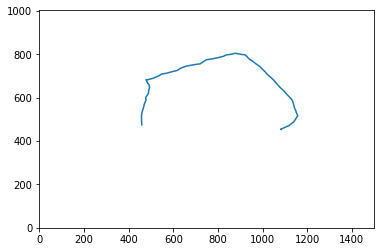

In [478]:
node = min_node
plt.plot(node["center_x"][0:100], -node["center_y"][0:100]+1003)
plt.xlim(0, 1500)
plt.ylim(0, 1003)